In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-clothing-store/products_skus.csv
/kaggle/input/ecommerce-clothing-store/products.csv
/kaggle/input/ecommerce-clothing-store/traffic.csv
/kaggle/input/ecommerce-clothing-store/orders_items.csv
/kaggle/input/ecommerce-clothing-store/orders.csv
/kaggle/input/ecommerce-clothing-store/customers.csv
/kaggle/input/ecommerce-clothing-store/transactions.csv


In [3]:
# The dataset of this project is from an online store, which includes product information and
# customer transaction records from 2016 to 2018. The ultimate goal of the company is to
# improve the sales. In this project, you’re supposed to find out the online shopping behaviors of
# the customers and make marketing suggestions for the store in order to increase the
# customers’ life-time value to the company.

In [4]:
customers = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/customers.csv') 
traffic = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/traffic.csv').drop(columns=['index'])
products = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products.csv')
prod_sku = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products_skus.csv')
orders = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders.csv')
ord_item = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders_items.csv')
transactions = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/transactions.csv')

In [5]:
# customer => website (traffic) => product/product sku => order/order items => transaction

### 1. How’s the trend of website traffic and the number of orders over time? 
- Is there any correlation between the orders and the website traffic?

<AxesSubplot:xlabel='date_day', ylabel='page_views'>

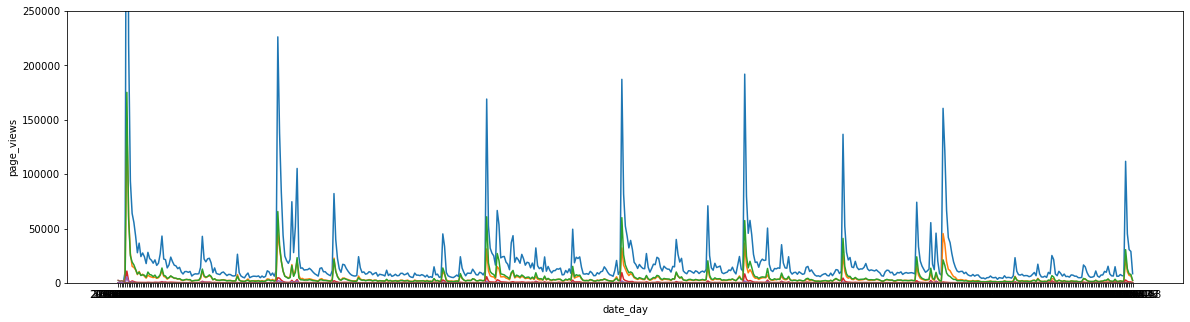

In [6]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))
plt.figure(figsize=(20, 5))
plt.ylim((0, 250000))
# pageview - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='page_views')
# sessions - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='sessions')
# prduct detail view - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_detail_views')
# product add to cart - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_adds_to_carts')
# product checkouts - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='product_checkouts')
# avg session s - time
sns.lineplot(data=traffic.sort_values(by=['date_day']), x='date_day', y='avg_session_in_s')

<AxesSubplot:xlabel='created_at', ylabel='num_order_created'>

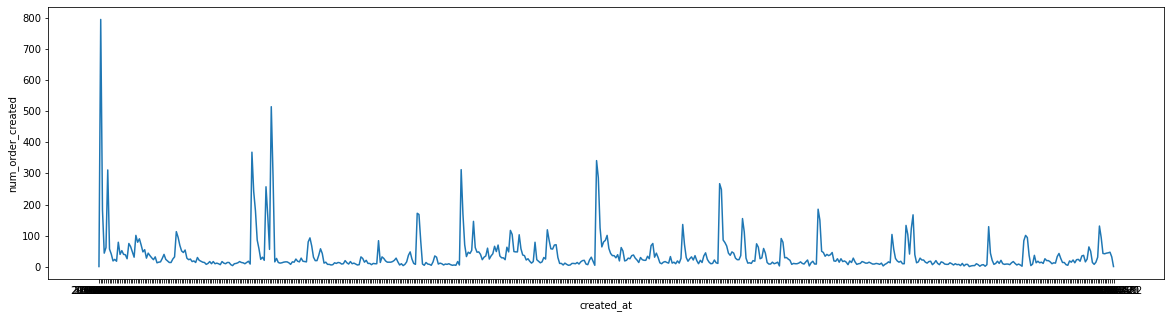

In [7]:
# order - time
order_by_time = orders.groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})
order_by_time_no_can = orders.loc[lambda x: x['cancelled_at'].isnull()].groupby(['created_at'])['id'].nunique().reset_index().rename(columns={'id':'num_order_created'})

plt.figure(figsize=(20, 5))
sns.lineplot(data=order_by_time, x='created_at', y='num_order_created')

Text(0, 0.5, 'product_checkouts (no cancellation)')

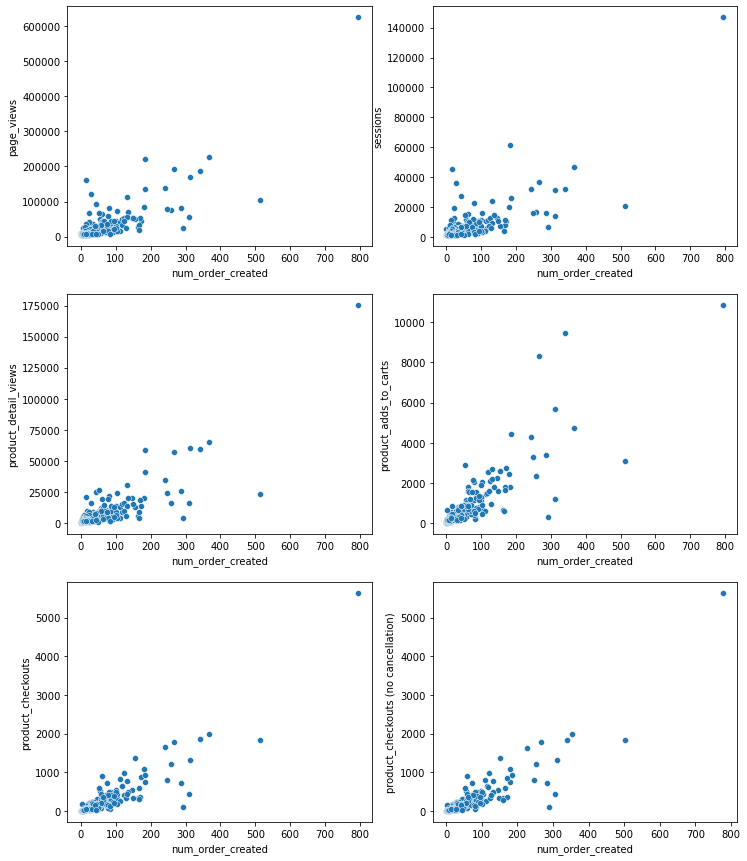

In [8]:
cor_traf_time = traffic.merge(order_by_time, 
                              left_on='date_day',
                              right_on='created_at').sort_values(by=['date_day'])
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.scatterplot(data=cor_traf_time, y='page_views', x='num_order_created', ax=ax1)
sns.scatterplot(data=cor_traf_time, y='sessions', x='num_order_created', ax=ax2)
sns.scatterplot(data=cor_traf_time, y='product_detail_views', x='num_order_created', ax=ax3)
sns.scatterplot(data=cor_traf_time, y='product_adds_to_carts', x='num_order_created', ax=ax4)
sns.scatterplot(data=cor_traf_time, y='product_checkouts', x='num_order_created', ax=ax5)

cor_traf_time_no_can = traffic.merge(order_by_time_no_can, 
                                     left_on='date_day',
                                     right_on='created_at').sort_values(by=['date_day'])
sns.scatterplot(data=cor_traf_time_no_can, y='product_checkouts', x='num_order_created', ax=ax6)
ax6.set_ylabel('product_checkouts (no cancellation)')

In [9]:
# 2. How’s the sales from the different products over the seasons or months? What are the popular products? Is there any correlation between different products?


In [10]:
prod_order = pd.merge(ord_item[['order_id', 'product_id', 'price', 'quantity']],
         products[['id', 'product_type', 'created_at','published_at']].rename(columns={'id':'product_id', 'created_at':'prod_created_at'}),
         on='product_id').merge(orders[['id', 'created_at', 'closed_at', 'cancelled_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']].rename(columns={'id':'order_id', 'created_at':'ord_created_at', 'closed_at':'ord_closed_at', 'cancelled_at':'ord_cancelled_at'}), on='order_id').sort_values(by=['order_id', 'product_id'])
prod_order

,order_id,product_id,price,quantity,product_type,prod_created_at,published_at,ord_created_at,ord_closed_at,ord_cancelled_at,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price
0,7675398239,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-21,2016-08-25,2016-08-22,44.57,6.33,35.0,0.0,35.0
663,7676331935,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-22,2016-08-22,NaN,124.55,0.00,114.0,0.0,114.0
664,7676331935,1.292763e+10,79.0,1,Bomber,2016-08-18,2016-08-18,2016-08-22,2016-08-22,NaN,124.55,0.00,114.0,0.0,114.0
2877,7676363167,1.292763e+10,25.0,1,Shirts,2016-08-18,2018-02-05,2016-08-22,NaN,2016-08-22,97.68,7.00,83.0,0.0,83.0
2876,7676363167,1.292806e+10,58.0,1,Trousers,2016-08-18,2016-08-18,2016-08-22,NaN,2016-08-22,97.68,7.00,83.0,0.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35823,940287628797,1.183022e+12,98.0,1,Blazer,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35824,940287628797,1.183022e+12,62.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35822,940287628797,1.183022e+12,65.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35825,940287628797,1.183022e+12,79.0,1,Jacket,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0


In [11]:
print('Total No. product types =', prod_order['product_type'].nunique())
prod_by_t = pd.pivot_table(prod_order,
               index='ord_created_at',
               columns='product_type',
               values='quantity',
               aggfunc=lambda x: sum(x),
               fill_value=0).reset_index().sort_values(by=['ord_created_at'])
prod_by_t.columns = [col.lower().replace(' ', '_') for col in prod_by_t.columns]
prod_by_t.head()

Total No. product types = 28


,ord_created_at,accessory,blazer,blouse,bodysuit,bomber,cardigan,dress,gift_card,hooide,...,top,tousers,trousers,tunic,crop_top,hoodie,maxi,midi,mini,romper
0,2016-08-21,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2016-08-22,0,74,84,39,48,28,95,0,126,...,84,46,65,200,0,0,0,0,0,0
2,2016-08-23,0,19,12,9,30,0,32,0,1,...,17,20,13,41,0,0,0,0,0,0
3,2016-08-24,0,6,3,2,5,0,5,0,0,...,3,6,4,4,0,0,0,0,0,0
4,2016-08-25,0,5,5,1,2,0,10,0,12,...,0,2,0,9,0,0,0,0,0,0


Here we will start with top6 most bought product types to see the sales seasonal trends.
Top6: ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']


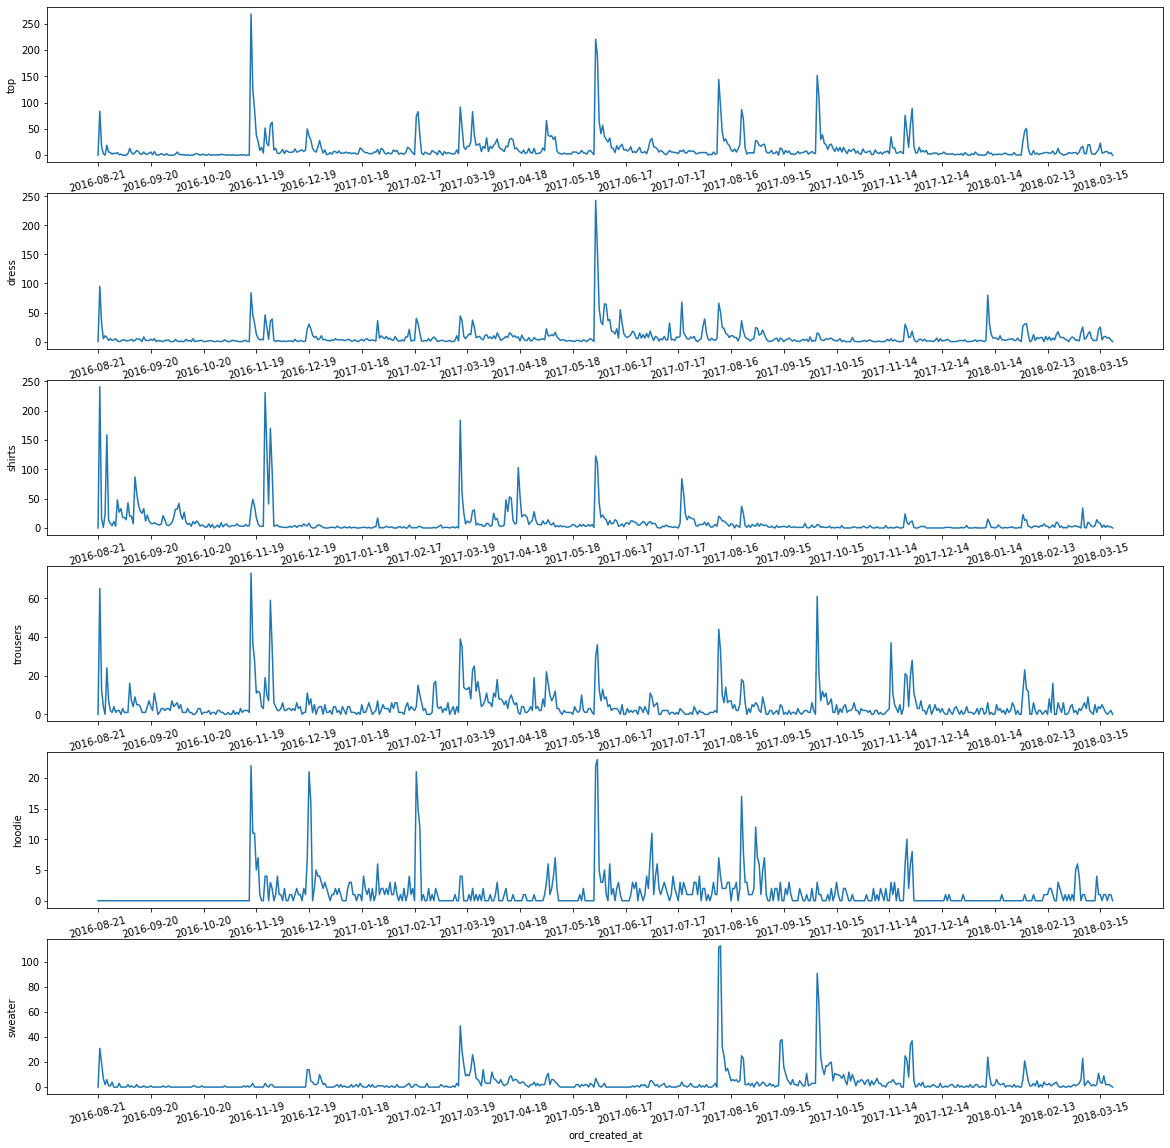

In [12]:
print('Here we will start with top6 most bought product types to see the sales seasonal trends.')
top6_prod_type_list = ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']
print('Top6:', top6_prod_type_list)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 20))
ind_list = np.arange(0, 577, 30)
for ax, col in zip((ax1, ax2, ax3, ax4, ax5, ax6), top6_prod_type_list):
    sns.lineplot(data=prod_by_t, x='ord_created_at', y=col, ax=ax)
    ax.set_xticks(ind_list)
    ax.set_xticklabels(labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=15)
#plt.xticks(ticks=ind_list, labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=30);

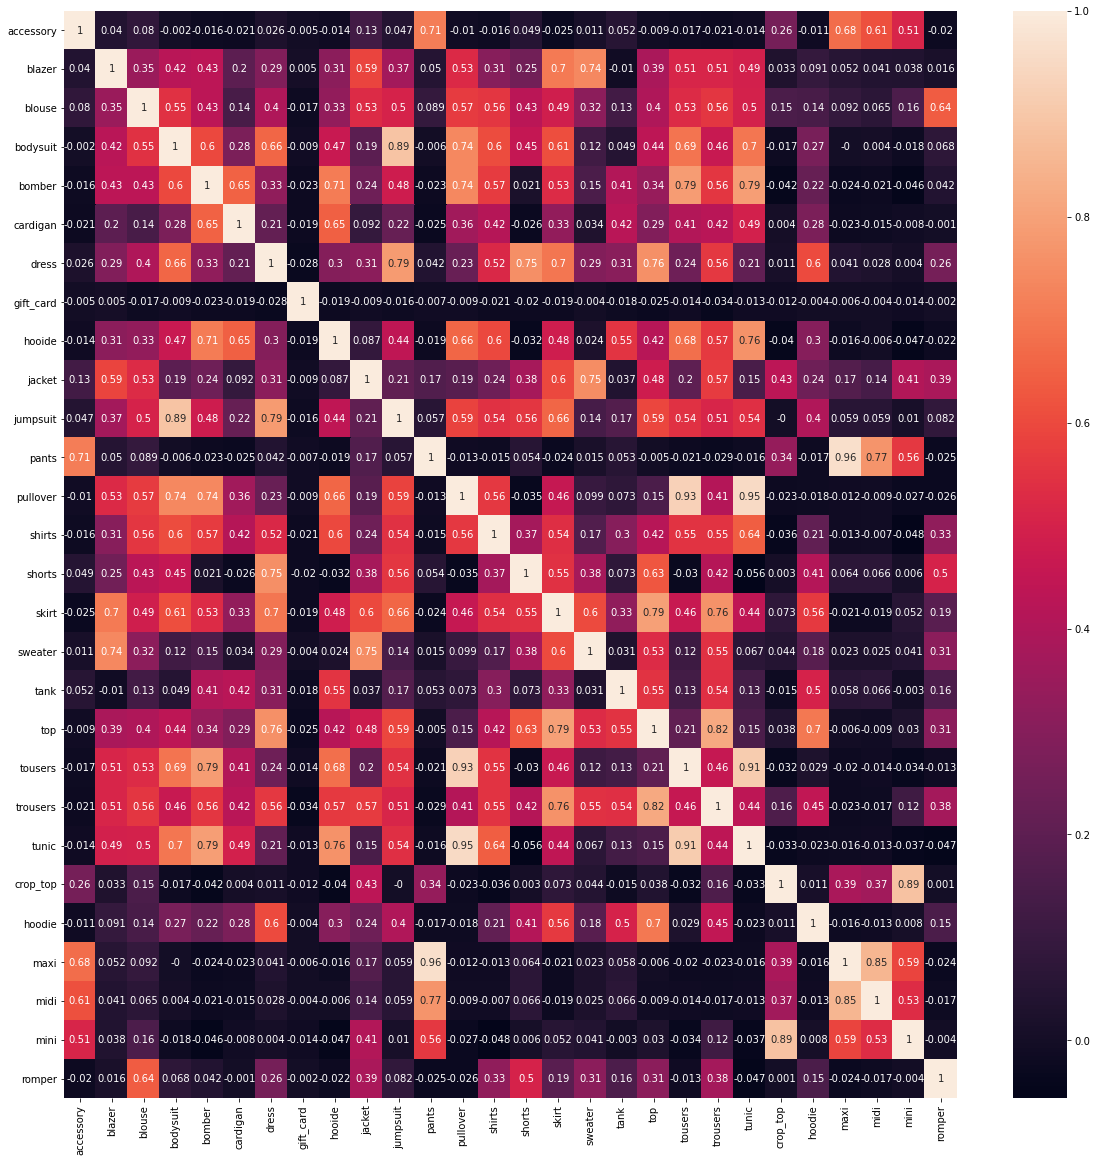

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.round(prod_by_t.drop(columns=['ord_created_at']).corr(), 3), annot=True);

In [14]:
prod_order

,order_id,product_id,price,quantity,product_type,prod_created_at,published_at,ord_created_at,ord_closed_at,ord_cancelled_at,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price
0,7675398239,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-21,2016-08-25,2016-08-22,44.57,6.33,35.0,0.0,35.0
663,7676331935,1.292763e+10,35.0,1,Tunic,2016-08-18,NaN,2016-08-22,2016-08-22,NaN,124.55,0.00,114.0,0.0,114.0
664,7676331935,1.292763e+10,79.0,1,Bomber,2016-08-18,2016-08-18,2016-08-22,2016-08-22,NaN,124.55,0.00,114.0,0.0,114.0
2877,7676363167,1.292763e+10,25.0,1,Shirts,2016-08-18,2018-02-05,2016-08-22,NaN,2016-08-22,97.68,7.00,83.0,0.0,83.0
2876,7676363167,1.292806e+10,58.0,1,Trousers,2016-08-18,2016-08-18,2016-08-22,NaN,2016-08-22,97.68,7.00,83.0,0.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35823,940287628797,1.183022e+12,98.0,1,Blazer,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35824,940287628797,1.183022e+12,62.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35822,940287628797,1.183022e+12,65.0,1,Pants,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0
35825,940287628797,1.183022e+12,79.0,1,Jacket,2018-03-08,2018-03-14,2018-03-22,NaN,NaN,404.00,0.00,404.0,0.0,404.0


In [15]:
prod_order.loc[lambda x: (x['total_discounts'] > 0) & (x['order_id'] == 7705038559)]

,order_id,product_id,price,quantity,product_type,prod_created_at,published_at,ord_created_at,ord_closed_at,ord_cancelled_at,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price
8885,7705038559,1.292805e+10,62.0,1,Jacket,2016-08-18,2016-08-18,2016-08-28,2016-08-29,NaN,7.0,7.0,0.0,172.0,172.0
8884,7705038559,1.292806e+10,45.0,1,Tousers,2016-08-18,2016-08-19,2016-08-28,2016-08-29,NaN,7.0,7.0,0.0,172.0,172.0
8883,7705038559,1.292806e+10,65.0,1,Blazer,2016-08-18,2016-08-18,2016-08-28,2016-08-29,NaN,7.0,7.0,0.0,172.0,172.0


<AxesSubplot:xlabel='quantity', ylabel='total_discounts_ratio'>

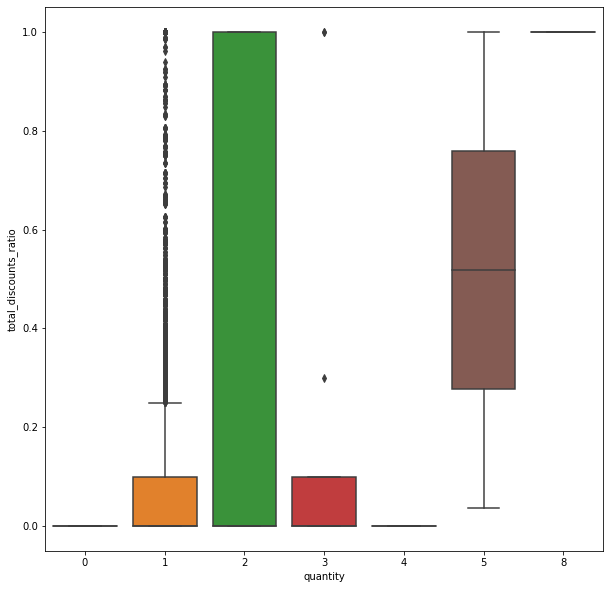

In [16]:
# 3. How’s the sales of different products with discount? Does the discount promote sales?
prod_order['total_discounts_ratio'] = np.round((prod_order['total_line_items_price'] - prod_order['subtotal_price']) / prod_order['total_line_items_price'], 4)

# In general
plt.figure(figsize=(10, 10))
sns.boxplot(data=prod_order, y='total_discounts_ratio', x='quantity')

In [37]:
#customers: ['id', 'full_name', 'created_at']
#orders: ['id', 'created_at', 'closed_at', 'cancelled_at', 'customer_id',
#         'financial_status', 'fulfillment_status', 'processed_at', 'total_price',
#         'shipping_rate', 'subtotal_price', 'total_discounts',
#         'total_line_items_price']
#transactions: ['order_id', 'id', 'parent_id', 'amount', 'error_code', 'kind', 'status', 'created_at']

In [53]:
customer_order = pd.merge(customers.rename(columns={'id':'customer_id', 'created_at':'customer_created_at'}),
         orders.rename(columns={'id':'order_id', 'created_at':'order_created_at'}),
         on='customer_id',
         how='left')[['customer_id', 'full_name', 'customer_created_at', 'order_created_at', 'total_price']].sort_values(by=['customer_id', 'order_created_at'])
# monthly churn rate: number of consumed customers in month i who didn't consume in month i+1 / number of consumed customers in month i 
customer_order['y_m'] = customer_order['order_created_at'].apply(lambda x: x[:7] if type(x) == str else x)
churn = customer_order.groupby(['customer_id', 'full_name', 'y_m'])['order_created_at'].any().reset_index()

churn_id_list = [] 
for customer in churn['customer_id'].unique():
    for y_m in churn['y_m'].unique():
        churn_id_list.append([customer, y_m])
churn = pd.merge(pd.DataFrame(churn_id_list, columns=['customer_id', 'y_m']),
                 churn,
                 on=['customer_id', 'y_m'],
                 how='left').sort_values(by=['customer_id', 'y_m'])

,customer_id,y_m,full_name,order_created_at,is_active,is_next_active
0,8683754719,2016-08,Donna Pierce,True,1,1.0
1,8683754719,2016-09,Donna Pierce,True,1,1.0
2,8683754719,2016-10,Donna Pierce,True,1,1.0
3,8683754719,2016-11,Donna Pierce,True,1,0.0
5,8683754719,2016-12,NaN,NaN,0,0.0
...,...,...,...,...,...,...
298654,1063480464893,2017-11,NaN,NaN,0,0.0
298651,1063480464893,2017-12,NaN,NaN,0,0.0
298659,1063480464893,2018-01,NaN,NaN,0,0.0
298652,1063480464893,2018-02,NaN,NaN,0,1.0


In [70]:
churn['is_active'] = churn['order_created_at'].apply(lambda x: 1 if x == True else 0)
churn['is_prev_active'] = churn['is_active'].shift(1).fillna(0)
churn.loc[(churn['is_prev_active'] == 1) & (churn['is_active'] == 0), 'is_churn'] = 1
churn['is_churn'] = churn['is_churn'].fillna(0)
churn.sort_values(by=['y_m'])
churn.groupby(['y_m']).apply(lambda x: x['is_churn'].sum() / x['is_prev_active'].sum()).reset_index()

,is_prev_active,is_active,is_churn
y_m,,,
2016-08,758.0,1433,720.0
2016-09,1433.0,1214,1310.0
2016-10,1214.0,823,1165.0
2016-11,823.0,2353,736.0
2016-12,2353.0,747,2257.0
2017-01,747.0,488,700.0
2017-02,488.0,759,454.0
2017-03,759.0,1251,704.0
2017-04,1251.0,1237,1123.0


In [18]:
# 4. Dig more into the data and gain more insights, you can choose some E-commerce metrics or analysis (e.g. churn rate, conversion rate, retention rate, RFM analysis). 

In [19]:
# 5. Based on the insights from all above questions, do you have any suggestion for the growth of sales?